<h2 style="text-align: center;">Generalized method of moments</h2>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize, curve_fit
from scipy.special import comb  # For binomial coefficients
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Let $(\Omega, \mathcal{F}, P)$ be a probability space. On this space, we define a standard Brownian motion $(W_t)_{t \geq 0}$ and its natural filtration $\mathcal{F} = (\mathcal{F}_t)_{t \geq 0}$. The Ornstein-Uhlenbeck process with parameters $(\kappa, \theta, \sigma)$ is the stochastic process solution to the following SDE:
$$
dX_t = \kappa (\theta - X_t) \, dt + \sigma \, dW_t, \quad X_0 = Y, \quad \mathcal{F}_0\text{-measurable}
$$
We use this simulate it : 
$$X_{t+h} = e^{-\kappa h} X_t + \theta \left( 1 - e^{-\kappa h} \right) + \sigma e^{-\kappa h} \int_{t}^{t+h} e^{-\kappa (t-s)} \, dW_s
$$
$$(Z[1], \dots, Z[n]) \sim \mathcal{N}(0, I_n)$$


$\text{For } k = 1, \dots, n \text{ do:}$
$$
\quad X[k] = e^{-\kappa h} X[k-1] + \theta \left( 1 - e^{-\kappa h} \right) + \sqrt{\frac{\sigma^2}{2\kappa}} \left( 1 - e^{-2\kappa h} \right) Z[k]$$
$$X_t \sim \mathcal{N} \left( e^{-\kappa t} X_0 + \theta (1 - e^{-\kappa t}), \frac{\sigma^2}{2\kappa} (1 - e^{-2\kappa t}) \right)$$


In [2]:
class Vasicek:
    def __init__(self, kappa, theta, sigma):
        """
        Initialize the parameters for the Vasicek model.
        
        :param kappa: Speed of mean reversion
        :param theta: Long-term mean level
        :param sigma: Volatility of the process
        """
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma

    def generate(self, X0, T, N, n):
        """
        Generate N trajectories of the Vasicek process on the interval [0, T] with a time step of T/n.
        
        :param X0: Initial value of the process
        :param T: The total time period
        :param N: Number of trajectories to generate
        :param n: Number of discretization steps (so time step is T/n)
        
        :return: Array of N trajectories discretized over the interval [0, T]
        """
        dt = T / n  # Adjusted time step for the interval [0, T]
        trajectories = np.zeros((N, n))  # Matrix to store the trajectories
        trajectories[:, 0] = X0  # Initialize all trajectories at X0

        for i in range(1, n):
            # Generate standard normal noise
            Z = np.random.randn(N)  # Standard normal random variables for each trajectory
            # Update the process value according to the Vasicek model
            trajectories[:, i] = (
                trajectories[:, i - 1] * np.exp(-self.kappa * dt)
                + self.theta * (1 - np.exp(-self.kappa * dt))
                +  np.sqrt((self.sigma**2) *(1 - np.exp(-2 * self.kappa * dt)) / (2 * self.kappa)) * Z
            )

        return trajectories


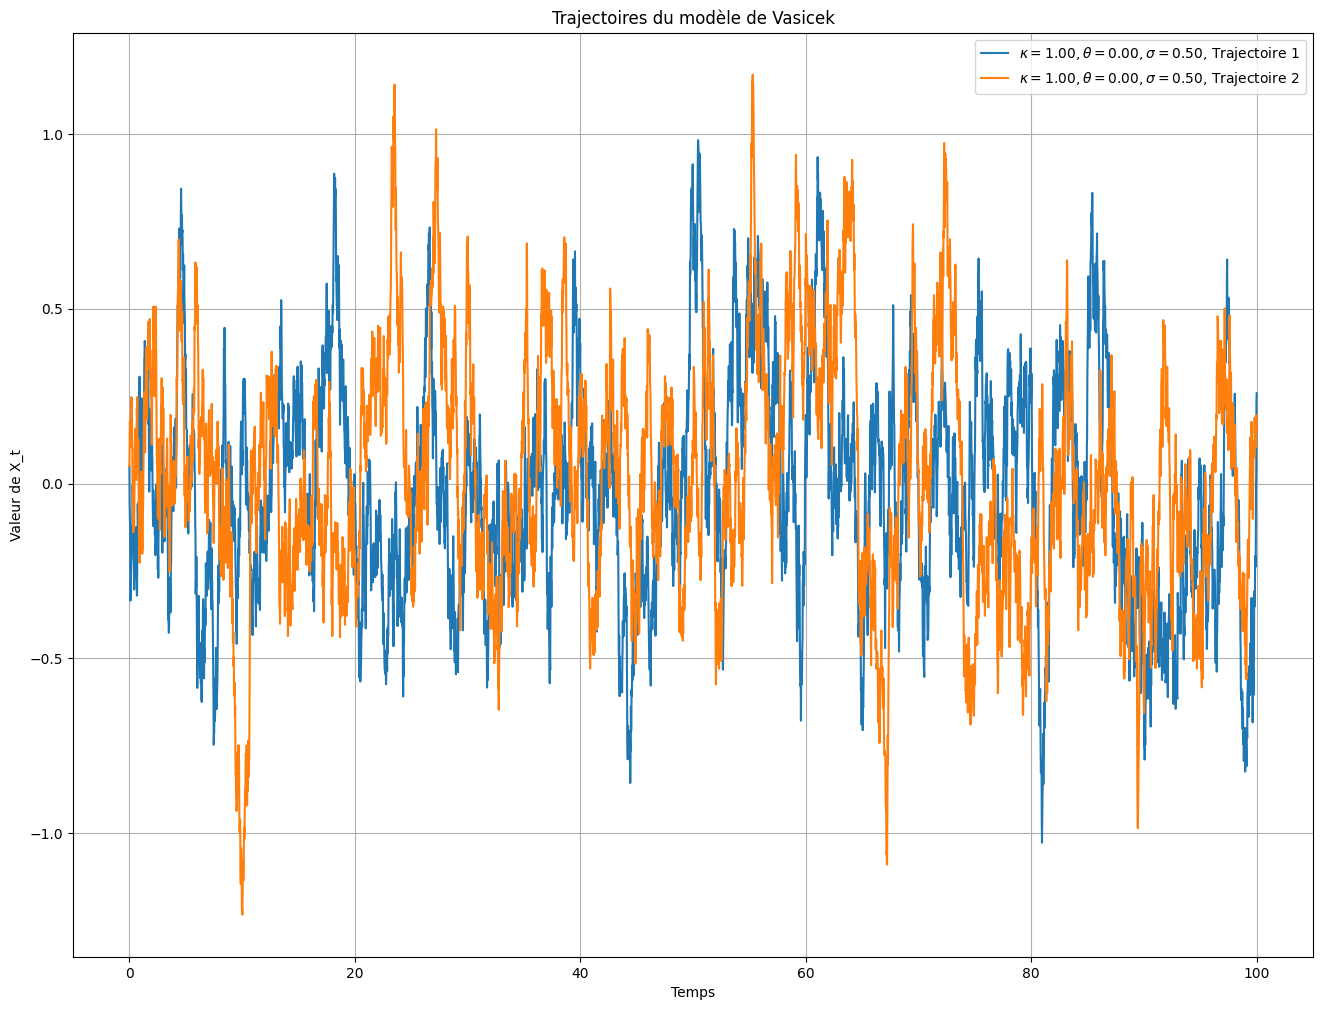

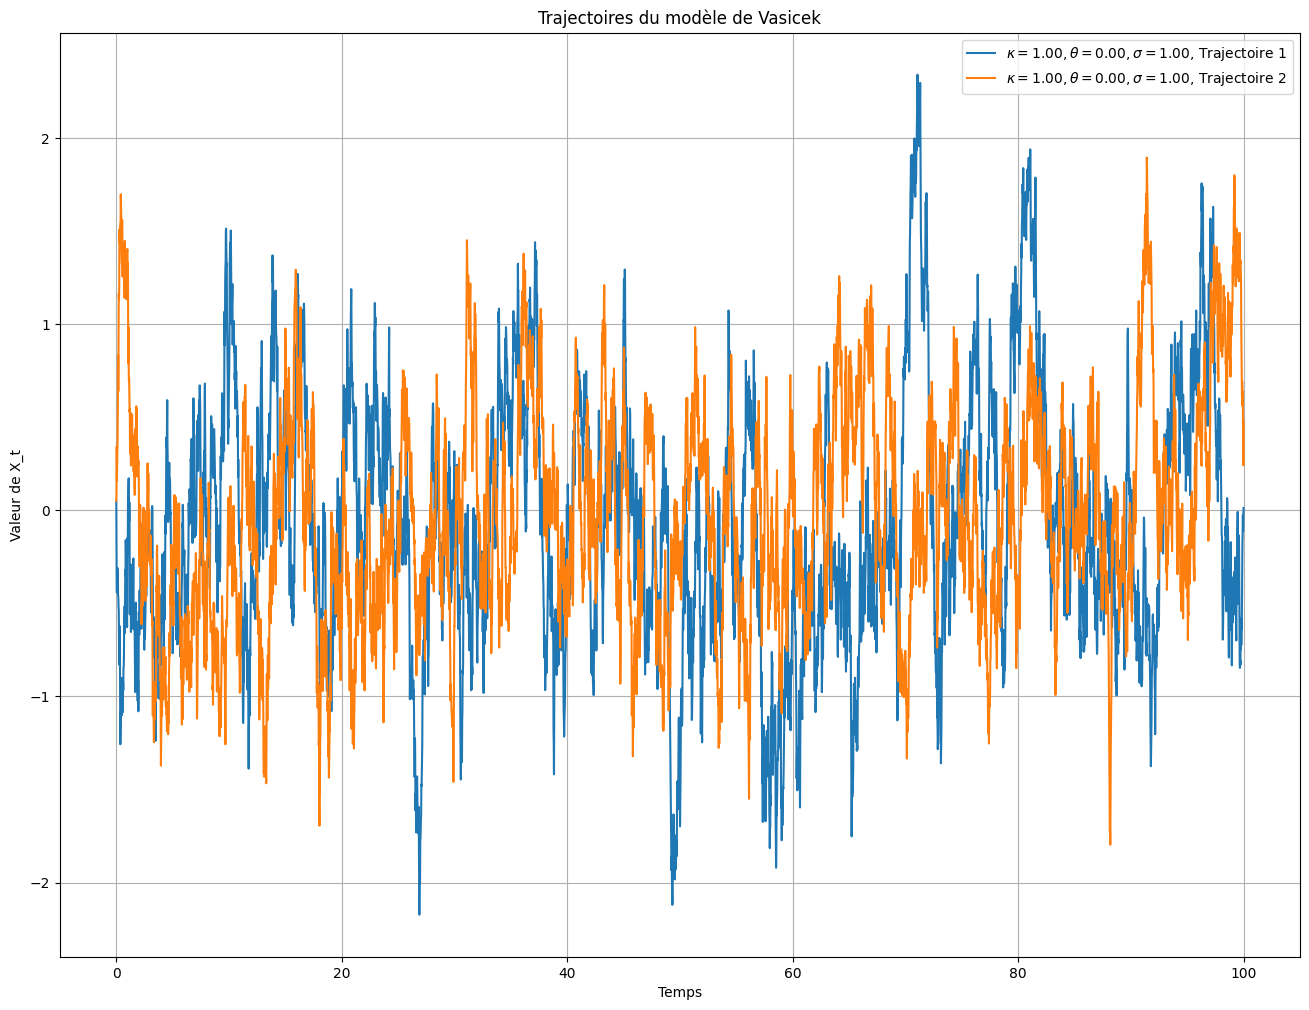

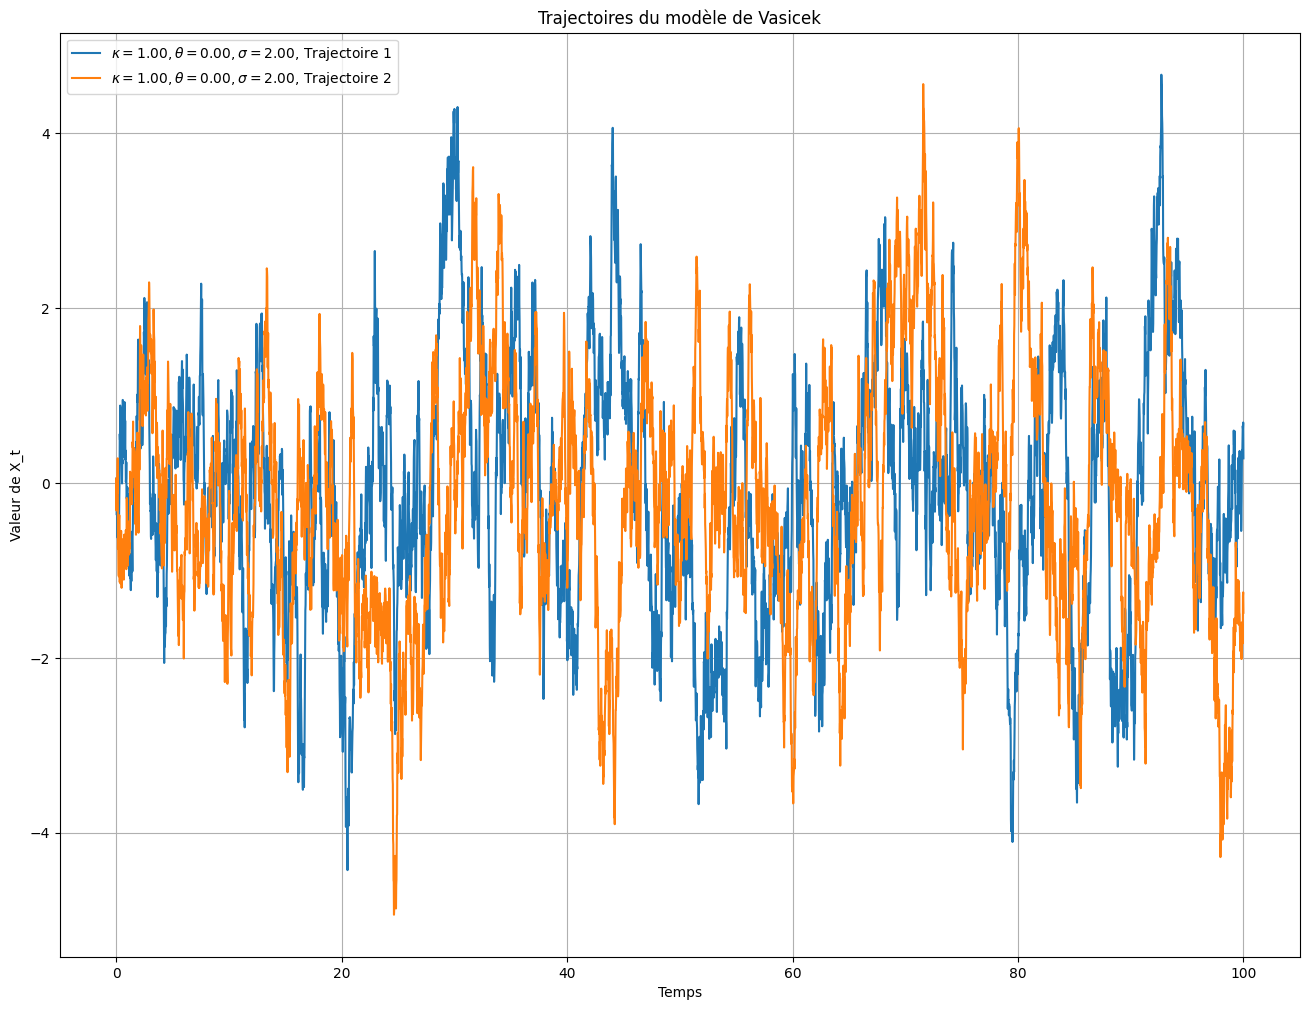

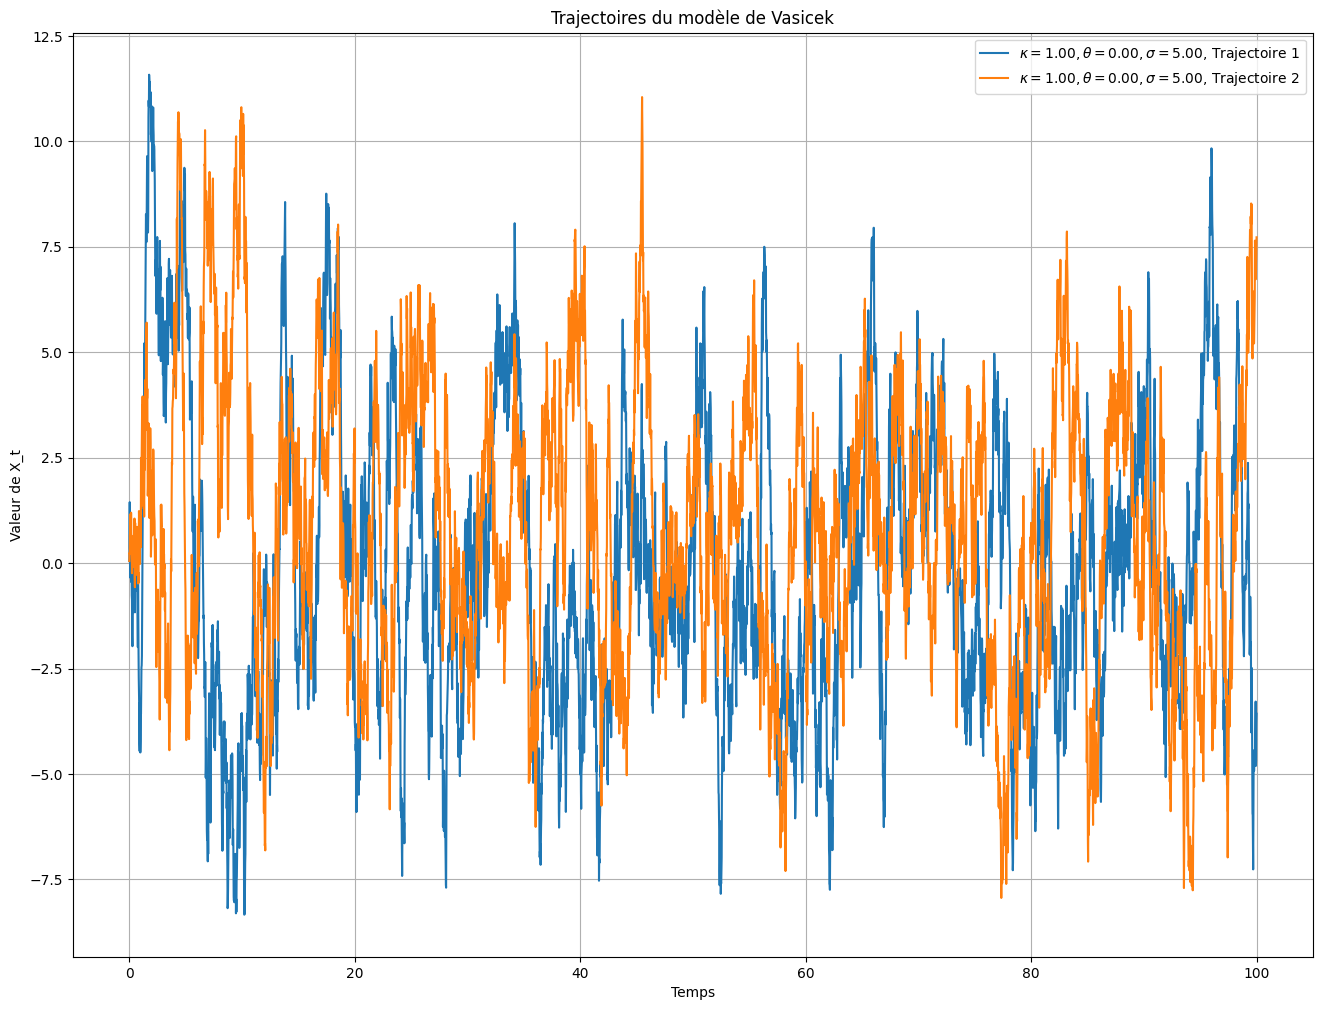

In [3]:
# Paramètres du modèle de Vasicek
kappa = 1  # vitesse de réversion vers la moyenne
theta = 0  # niveau de la moyenne à long terme
X0 = 0.05  # valeur initiale
N = 2  # nombre de trajectoires à générer
n = 5000  # nombre de pas de discrétisation
T = 100  # durée totale

# Liste des valeurs de sigma
sigma_values = [0.5, 1, 2, 5]

# Créer un objet de la classe Vasicek et générer les trajectoires pour chaque valeur de sigma
for sigma in sigma_values:
    # Créer un objet avec la valeur de sigma courante
    plt.figure(figsize=(16, 12))
    vasicek_process = Vasicek(kappa, theta, sigma)
    
    # Générer les trajectoires
    trajectories = vasicek_process.generate(X0, T, N, n)  # Correction: Pass X0, T, N, n
    
    # Affichage des trajectoires générées pour chaque sigma
    time = np.linspace(0, T, n)
    for i in range(N):
        plt.plot(time, trajectories[i], label=f"$\\kappa = {kappa:.2f}, \\theta = {theta:.2f}, \\sigma = {sigma:.2f}$, Trajectoire {i+1}")
    plt.title("Trajectoires du modèle de Vasicek")
    plt.xlabel("Temps")
    plt.ylabel("Valeur de X_t")
    plt.legend()
    plt.grid(True)
    plt.show()


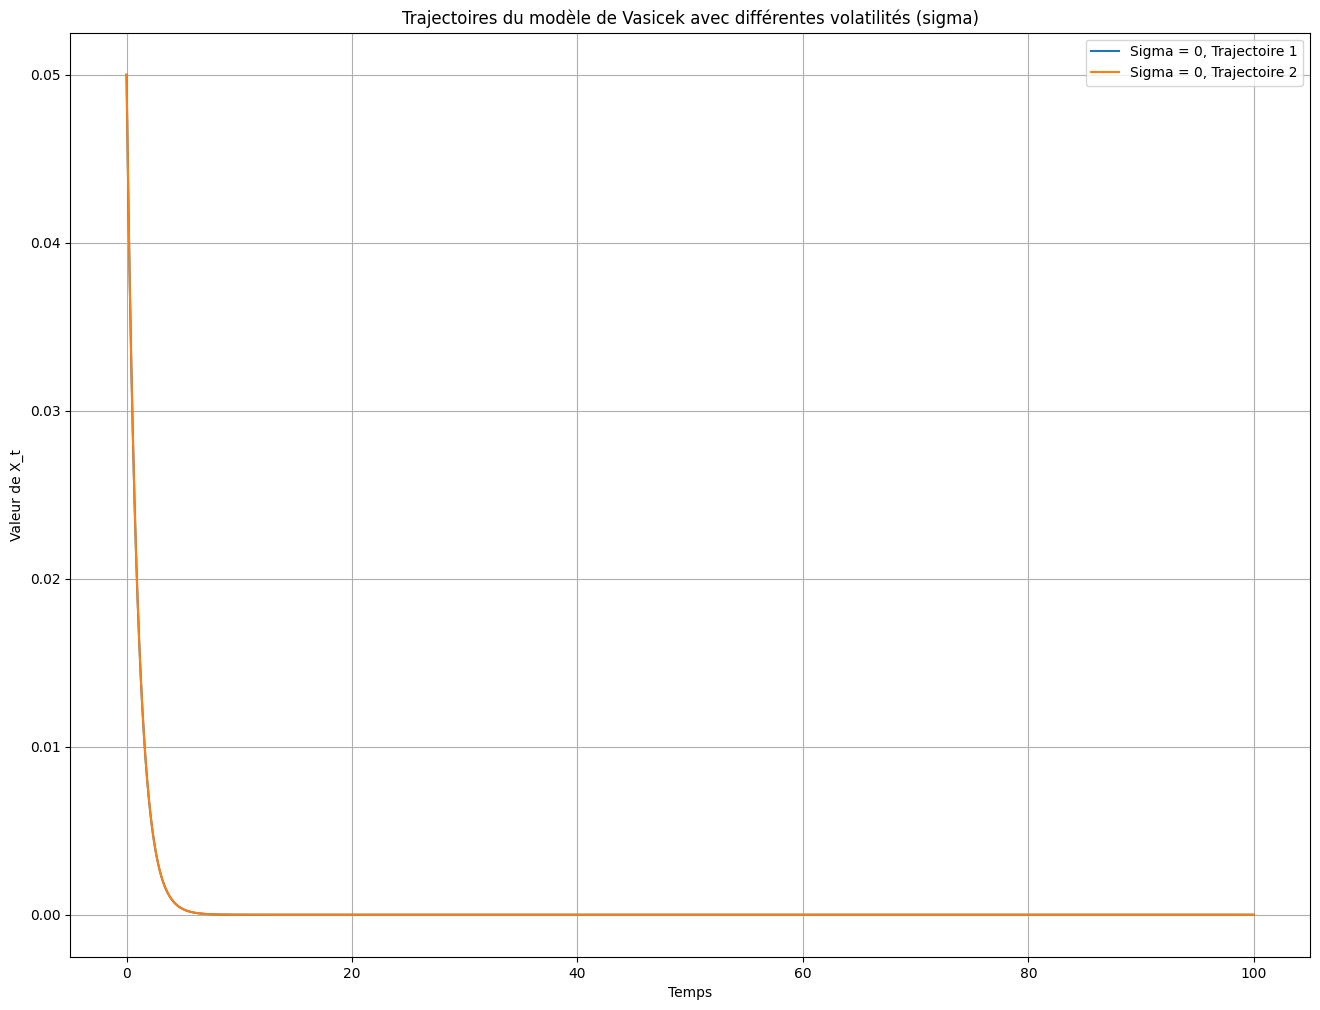

In [4]:
# Paramètres du modèle de Vasicek
kappa = 1  # vitesse de réversion vers la moyenne
theta = 0  # niveau de la moyenne à long terme
X0 = 0.05  # valeur initiale
N = 2  # nombre de trajectoires à générer
n = 5000  # nombre de pas de discrétisation
T = 100  # durée totale

# Liste des valeurs de sigma
sigma_values = [0]

# Créer un objet de la classe Vasicek et générer les trajectoires pour chaque valeur de sigma
for sigma in sigma_values:
    # Créer un objet avec la valeur de sigma courante
    plt.figure(figsize=(16, 12))
    vasicek_process = Vasicek(kappa, theta, sigma)
    
    # Générer les trajectoires
    trajectories = vasicek_process.generate(X0, T, N, n)  # Correction: Pass X0, T, N, n
    
    # Affichage des trajectoires générées pour chaque sigma
    time = np.linspace(0, T, n)
    for i in range(N):
        plt.plot(time, trajectories[i], label=f"Sigma = {sigma}, Trajectoire {i+1}")
    
    plt.title("Trajectoires du modèle de Vasicek avec différentes volatilités (sigma)")
    plt.xlabel("Temps")
    plt.ylabel("Valeur de X_t")
    plt.legend()
    plt.grid(True)
    plt.show()

La fonction suivante calcule la quantité :
$$\frac{1}{n} \sum_{k=0}^n f(X_{t_k})$$
Il s'agit de la moyenne temporelle du processus sur les $n$ instants.

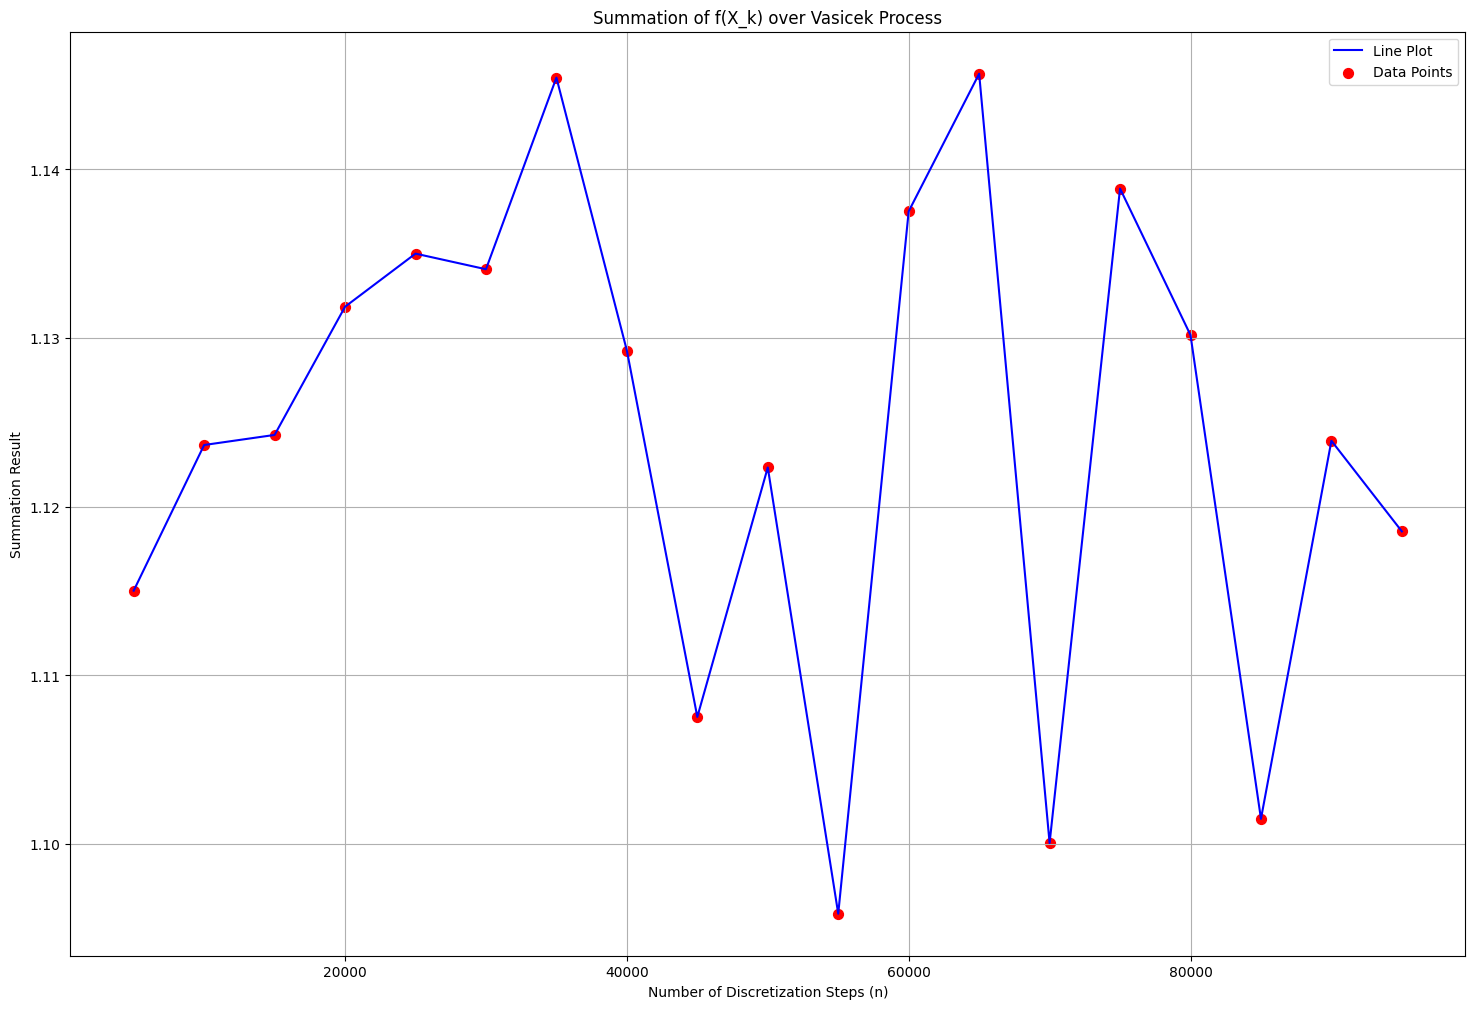

In [5]:
def calculate_sum(n, f, kappa=1, theta=1, sigma=0.5, X0=0.05,T=5000):
    """
    Calculate the summation: (1/n) * sum_{k=0}^n f(X_k), where X_k is generated by the Vasicek model.
    
    :param n: Number of steps in the discretization
    :param f: Function to apply to each X_k
    :param kappa: Speed of mean reversion
    :param theta: Long-term mean level
    :param sigma: Volatility
    :param X0: Initial value of the process
    :return: The computed summation
    """
    vasicek_process = Vasicek(kappa, theta, sigma)
      # Time horizon

    # Generate one trajectory
    trajectories = vasicek_process.generate(X0, T, 1, n)  # One trajectory, n steps
    res = 0
    trajectory = trajectories[0]  # Take the first trajectory
    res +=(1 / n) * sum(f(x) for x in trajectory)
    # Compute the summation
    return res

# Define the function to apply to each X_k
f = lambda x: x**2  # Example: Square of each value

n_values = range(5000, 100000, 5000)  # Range of n values for testing
Y = [calculate_sum(n, f) for n in n_values]  # Compute the result for each n
# Plot the results
plt.figure(figsize=(18, 12))
plt.plot(n_values, Y, label="Line Plot", color="blue")  # Line plot
plt.scatter(n_values, Y, label="Data Points", color="red", s=50)  # Scatter plot
plt.xlabel("Number of Discretization Steps (n)")
plt.ylabel("Summation Result")
plt.title("Summation of f(X_k) over Vasicek Process")
plt.grid(True)
plt.legend()  # Add a legend to differentiate the line and scatter plots
plt.show()

This function calculates this quantity :
$$\mathbb{E} (X_{\infty}^n)=\sum_{k=0}^n \binom{k}{n} \theta^{n-k} \frac{\sigma^k}{(2 \kappa)^{k/2}} \mathbb{E} (Z^k)$$
where $Z \sim \mathcal{N}(0,1)$

In [6]:
def expected_value_vasicek(power, theta, sigma, kappa):
    """
    Compute the expected value of the Vasicek process at X_n using the closed-form formula.
    
    :param n: Number of steps in the discretization
    :param theta: Long-term mean level
    :param sigma: Volatility
    :param kappa: Speed of mean reversion
    :return: The theoretical expected value
    """
    expected_sum = 0
    for k in range(power + 1):
        # Binomial coefficient
        binom_coeff = comb(power, k)
        
        # Factor for theta and sigma
        theta_factor = theta**(power - k)
        sigma_factor = sigma**k / (2 * kappa)**(k//2)
        
        # Expectation of Z^k
        if k % 2 == 0:  # Even powers of Z
            m = k // 2
            # For even k, the expectation of Z^{2m} is (2m-1)!! = (2m-1)*(2m-3)*...*1
            z_expectation = math.factorial(2 * m) // (2**m * math.factorial(m))  # Double factorial calculation
        else:  # Odd powers of Z
            z_expectation = 0
        
        # Add to the summation
        expected_sum += binom_coeff * theta_factor * sigma_factor * z_expectation
    
    return expected_sum


# Parameters for Vasicek
kappa_true = 1  # True speed of mean reversion
theta_true = 0.5  # True long-term mean
sigma_true = 0.2  # True volatility
n = 2

# Compute theoretical expectation
true_value = expected_value_vasicek(n, theta, sigma, kappa)
print("Theoretical Expected Value:", true_value)


Theoretical Expected Value: 0.0


Theoretical Expected Value: 0.27
Average of computed Summation: 0.26851523769642976


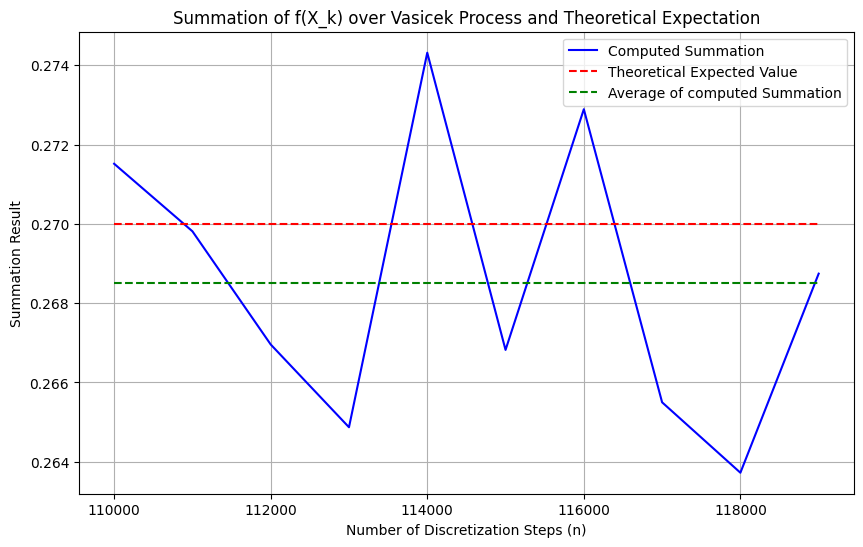

In [7]:
# Example parameters
kappa = 1  # Speed of mean reversion
theta = 1  # Long-term mean level
sigma = 0  # Volatility
X0 = 0.05  # Initial value
N = 1  # Only 1 trajectory for the summation computation
n_values = range(110000, 120000, 1000)  # Range of n values for testing
n = 2 # Choose a large n for comparison

# Define the function to apply to each X_k
f = lambda x: x**n# Example: x^3

# Compute the summation for each value of n
Y = [calculate_sum(n, f, kappa=kappa_true, theta=theta_true, sigma=sigma_true, X0=X0) for n in n_values]
y0 = sum(Y)/len(Y)
# Compute the true value of the expectation
true_value = expected_value_vasicek(n, theta_true, sigma_true, kappa_true)
Y0 = [true_value for _ in n_values]  # Create a constant list for the theoretical expected value
Y1 = [y0 for _ in n_values]
# Print the theoretical expected value
print("Theoretical Expected Value:", true_value)
print("Average of computed Summation:", y0)
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_values, Y, label="Computed Summation", color="blue")
plt.plot(n_values, Y0, label="Theoretical Expected Value", color="red", linestyle="--")
plt.plot(n_values, Y1, label="Average of computed Summation", color="green", linestyle="--")
plt.xlabel("Number of Discretization Steps (n)")
plt.ylabel("Summation Result")
plt.title("Summation of f(X_k) over Vasicek Process and Theoretical Expectation")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
"""
def parameter_estimator():
    # Initial guess for [theta, sigma, kappa]
    initial_guess = [0.1, 0.2, 0.1]
    print("Initial Guess:", initial_guess)
    # theta, sigma, kappa = params
    # Perform minimization with Nelder-Mead
    res = minimize(matrix_calculator, initial_guess, method='Nelder-Mead',
                   options={'xatol': 1e-6, 'maxfev': 10000, 'disp': True})
    
    
    # Output the results
    print("Optimization Success:", res.success)   # Check if optimization succeeded
    print("Optimization Message:", res.message)   # Check why it may have failed
    print("Final Objective Function Value:", res.fun)  # Final value of the objective function
    print("Optimized Parameters:", res.x)         # Optimized parameters (theta, sigma, kappa)
    
    return res.x

# Example usage
print("True Parameters:", [theta_true, sigma_true, kappa_true])
optimized_params = parameter_estimator()
print("Optimized Parameters:", optimized_params)
print("True Parameters:", [theta_true, sigma_true, kappa_true])
print("True error value :",matrix_calculator((theta_true, sigma_true, kappa_true)))"""

'\ndef parameter_estimator():\n    # Initial guess for [theta, sigma, kappa]\n    initial_guess = [0.1, 0.2, 0.1]\n    print("Initial Guess:", initial_guess)\n    # theta, sigma, kappa = params\n    # Perform minimization with Nelder-Mead\n    res = minimize(matrix_calculator, initial_guess, method=\'Nelder-Mead\',\n                   options={\'xatol\': 1e-6, \'maxfev\': 10000, \'disp\': True})\n    \n    \n    # Output the results\n    print("Optimization Success:", res.success)   # Check if optimization succeeded\n    print("Optimization Message:", res.message)   # Check why it may have failed\n    print("Final Objective Function Value:", res.fun)  # Final value of the objective function\n    print("Optimized Parameters:", res.x)         # Optimized parameters (theta, sigma, kappa)\n    \n    return res.x\n\n# Example usage\nprint("True Parameters:", [theta_true, sigma_true, kappa_true])\noptimized_params = parameter_estimator()\nprint("Optimized Parameters:", optimized_params)\npri

# Estimation by "pure" moments

[1.2407586  0.41191479 1.15890268]


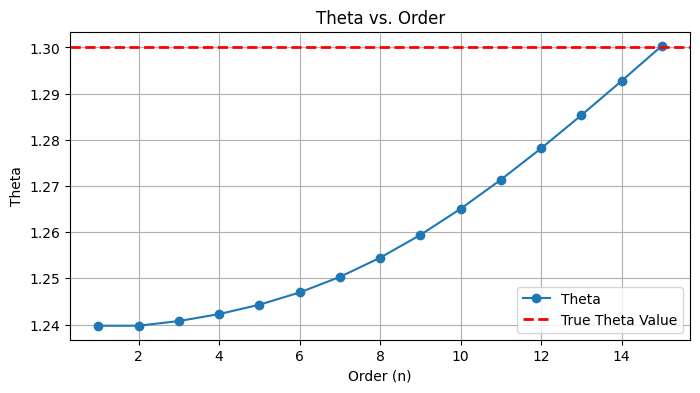

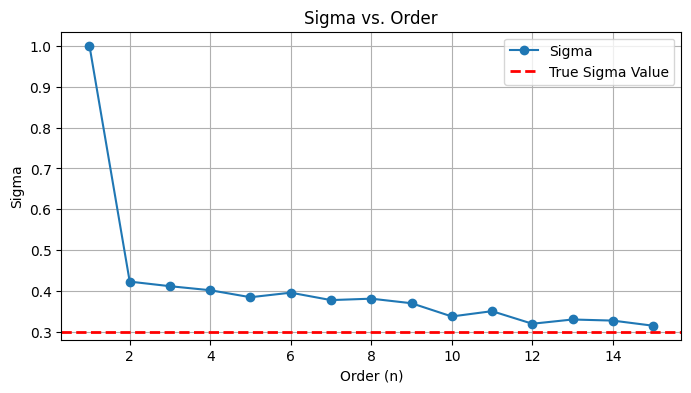

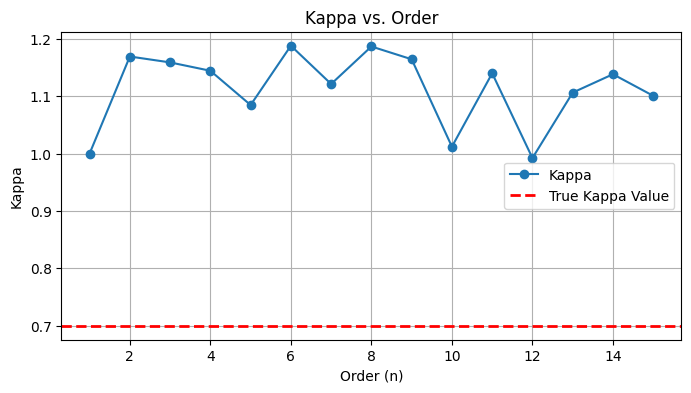

In [9]:

def empirical_value_vasicek(X, order):
    res = 0
    n = len(X)
    for i in range(n):
        res += X[i]**order
    return res/n

def pure_moments_calibration(X, max_order):
    orders = np.array([i for i in range(1, max_order+1)])
    y_obs = empirical_value_vasicek(X, orders)
    
    def cost(params):
        theta, sigma, kappa = params
        errors = [expected_value_vasicek(i+1, theta, sigma, kappa)-y_obs[i] for i in range(0, max_order)]
        return np.sum(np.square(errors))
    
    initial_guess = [1.0, 1.0, 1.0]  # Devine un point de départ
    result = minimize(cost, initial_guess, method='L-BFGS-B', bounds=[(None, None), (0, None), (None, None)])
    return(result.x)

n = 5000
T = 100

theta = 1.3
sigma = 0.3
kappa = 0.7

vasicek_process = Vasicek(kappa, theta, sigma)
X = vasicek_process.generate(X0, T, 1, n)[0]

res = pure_moments_calibration(X, 3)
print(res)

# Calculer pure_moments_calibration pour chaque ordre
max_order = 15
n_values = range(1, max_order + 1)
calibration_values = [pure_moments_calibration(X, n) for n in n_values]

# Définir les vraies valeurs des paramètres
true_values = {
    'Theta': theta,
    'Sigma': sigma,
    'Kappa': kappa
}

# Extraire correctement les paramètres de calibration_values
theta_values = [params[0] for params in calibration_values]
sigma_values = [params[1] for params in calibration_values]
kappa_values = [params[2] for params in calibration_values]

# Créer un dictionnaire pour les paramètres et leurs étiquettes
parameters = {
    'Theta': theta_values,
    'Sigma': sigma_values,
    'Kappa': kappa_values
}

# Boucle pour tracer chaque graphe avec la ligne horizontale de la vraie valeur
for param_name, param_values in parameters.items():
    plt.figure(figsize=(8, 4))
    plt.plot(n_values, param_values, marker='o', linestyle='-', label=param_name)
    
    # Ajouter la ligne horizontale représentant la vraie valeur
    plt.axhline(y=true_values[param_name], color='red', linestyle='--', linewidth=2, label=f'True {param_name} Value')

    # Ajouter les labels et le titre
    plt.xlabel('Order (n)')
    plt.ylabel(param_name)
    plt.title(f'{param_name} vs. Order')
    plt.legend()
    plt.grid(True)
    plt.show()



## Estimation by First and Second-Order Moments

Here, I will present my theoretical results used for estimation in the Vasicek model.  
I used only the first two moments to estimate both \( \sigma \) and \( \kappa \). We will later see if we can improve this method.

$$
\bar{\theta} = \frac{1}{n} \sum_{i=1}^{n} X_i
$$

Let us define:

$$
X_0 = \bar{\theta}^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+1}
$$

$$
X_1 = \bar{\theta}^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+2}
$$

$$
h = \frac{T}{n}
$$
# Objective Function Minimization
The objective function is:
$$
L(\kappa, \sigma^2) = \left( \frac{\sigma^2}{2\kappa} e^{-\kappa h} - X_0 \right)^2 + \left( \frac{\sigma^2}{2\kappa} e^{-2\kappa h} - X_1 \right)^2 
$$



This is clearly achieved when :
$$\frac{\sigma^2}{2\kappa} e^{-\kappa h} - X_0  = 0 $$
and 
$$ \frac{\sigma^2}{2\kappa} e^{-2\kappa h} - X_1 =  0 $$

$$ e^{-\kappa h} = \frac{X_1}{X_0} $$
$$ \sigma ^2  = 2 \kappa  X_0 e^{\kappa h} = \frac{2 \kappa X_0^2}{X_1} $$


Finally, we have these results : 
$$\bar{\kappa} = \frac{1}{h} \ln( {\frac{(\frac{1}{n} \sum_{i=1}^{n} X_i)^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+1}}{(\frac{1}{n} \sum_{i=1}^{n} X_i)^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+2}}})$$
$\newline$

$$\bar {\sigma^2} = 2 \bar {\kappa} \frac{((\frac{1}{n} \sum_{i=1}^{n} X_i)^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+1})^2}{(\frac{1}{n} \sum_{i=1}^{n} X_i)^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+2}}$$
$$\bar{\theta} = \frac{1}{n} \sum_{i=1}^{n} X_i$$

This is done with the normal moments method. We should of course extend this to the generalized method of moments and with lag terms.




In [10]:
# Generate Vasicek process trajectories 
# True parameters
kappa_true = 0.892  # Vitesse de retour à la moyenne
theta_true = 0.09  # Moyenne long-terme
sigma_true = 0.033  # Volatilité
vasicek_process = Vasicek(kappa_true, theta_true, sigma_true)
X0 = 0.05  # Initial value
T = 1000  # Time horizon
N = 1  # Number of trajectories
n = 100000  # Number of time steps
trajectories = vasicek_process.generate(X0, T, N, n)
trajectory = trajectories[0]
print(np.mean(trajectory))


0.49525776882984135


Empirical theta is: 0.49525776882984135
True theta is: 0.5
Number of Lags:  1


/tmp/ipykernel_1199800/1529027481.py:25: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(


Number of Lags:  2
Number of Lags:  3
Number of Lags:  4
Number of Lags:  5
Number of Lags:  6
Number of Lags:  7
Number of Lags:  8
Number of Lags:  9
Number of Lags:  10
Number of Lags:  11
Number of Lags:  12
Number of Lags:  13
Number of Lags:  14
Number of Lags:  15
Number of Lags:  16
Number of Lags:  17
Number of Lags:  18
Number of Lags:  19
Number of Lags:  20
Number of Lags:  21
Number of Lags:  22
Number of Lags:  23
Number of Lags:  24


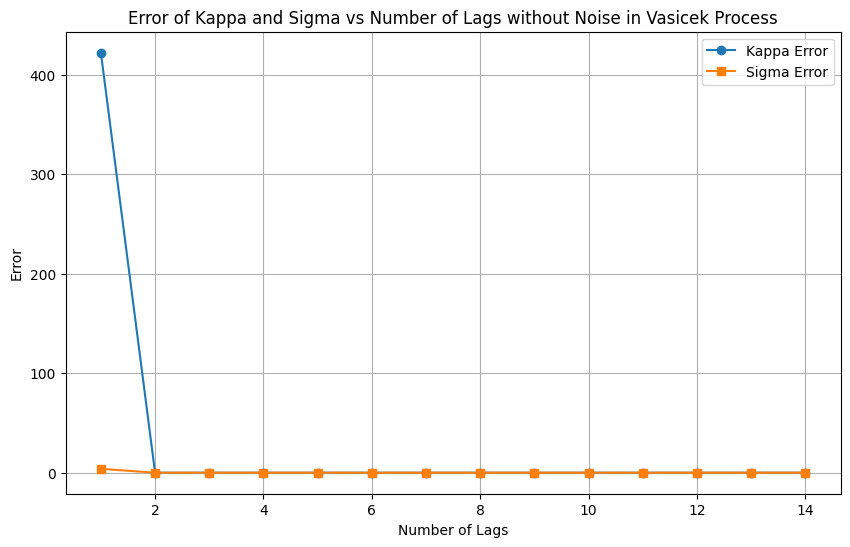

True kappa is: 1.0
True sigma is: 0.2
Estimated kappa is: 0.9643999699762097
Estimated sigma is: 0.19749502487079892


In [11]:
# Theoretical covariance function
def theoretical_covariance(h, kappa, sigma):
    return (sigma**2 / (2 * kappa)) * np.exp(-kappa * h)

# Empirical covariance function
def empirical_covariance(X, n, T, theta_emp, h):
    k0 = int(n * h / T)  # Convert lag h to index
    cov = 0
    for k in range(n - k0):
        cov += (X[k] * X[k + k0]) / (n - k0)
    return cov - theta_emp**2

# Function to estimate kappa and sigma
p0 = [3.9, 1.5]  # Initial guesses for kappa and sigma

def estimate_kappa_sigma(X, n, T, theta_emp, lags):
    def emp_cov(X, h):
        return empirical_covariance(X, n, T, theta_emp, h)
    
    # Calculate empirical covariances for the given lags
    covariances = np.array([emp_cov(X, h) for h in lags])
    
    # Fit the theoretical covariance function to the empirical covariances
    bounds = ([0, 0], [np.inf, np.inf])  # Ensure positive kappa and sigma
    params, _ = curve_fit(
        lambda h, kappa, sigma: theoretical_covariance(h, kappa, sigma),
        lags,
        covariances,
        p0=p0,
        bounds=bounds,
    )
    kappa, sigma = params
    return kappa, sigma

# Compute empirical mean
theta_emp = np.mean(trajectory)
print("Empirical theta is:", theta_emp)
print("True theta is:", theta_true)

# Define the range of lags
num_lags_list = np.arange(5, 25, 1)  # Start with 20, increase by 20, up to 200
kappa_errors = []
sigma_errors = []
kappa_est = -1 
sigma_est = -1
# Loop over the number of lags to calculate errors
for num_lags in num_lags_list:
    print("Number of Lags: ", num_lags)
    lags = np.array([i * T / n for i in range(num_lags)])  # Define lags
    kappa_est, sigma_est = estimate_kappa_sigma(trajectory, n, T, theta_emp, lags)
    kappa_errors.append(np.abs(kappa_est - kappa_true))  # Absolute error for kappa
    sigma_errors.append(np.abs(sigma_est - sigma_true))  # Absolute error for sigma

# Plot the errors
plt.figure(figsize=(10, 6))
plt.plot(num_lags_list, kappa_errors, label='Kappa Error', marker='o')
plt.plot(num_lags_list, sigma_errors, label='Sigma Error', marker='s')
plt.xlabel('Number of Lags')
plt.ylabel('Error')
plt.title('Error of Kappa and Sigma vs Number of Lags without Noise in Vasicek Process')
plt.legend()
plt.grid(True)
plt.show()
print("True kappa is:", kappa_true)
print("True sigma is:", sigma_true)
print("Estimated kappa is:", kappa_est)
print("Estimated sigma is:", sigma_est)

In [12]:
# Generate Vasicek process trajectories 
# True parameters
kappa_true = 0.892  # Vitesse de retour à la moyenne
theta_true = 0.09  # Moyenne long-terme
sigma_true = 0.033  # Volatilité
vasicek_process = Vasicek(kappa_true, theta_true, sigma_true)
X0 = theta_true  # Initial value
N = 1  # Number of trajectories
n = 100000  # Number of time steps
T =  1000   # Time horizon
trajectories = vasicek_process.generate(X0, T, N, n)
trajectory = trajectories[0]
s = 0
for i in range(len(trajectory)) :
    trajectory[i] =trajectory[i] 


Empirical theta is: 0.5604316235886628
True theta is: 0.5
Number of Lags:  20
Number of Lags:  40
Number of Lags:  60
Number of Lags:  80
Number of Lags:  100
Number of Lags:  120
Number of Lags:  140
Number of Lags:  160
Number of Lags:  180


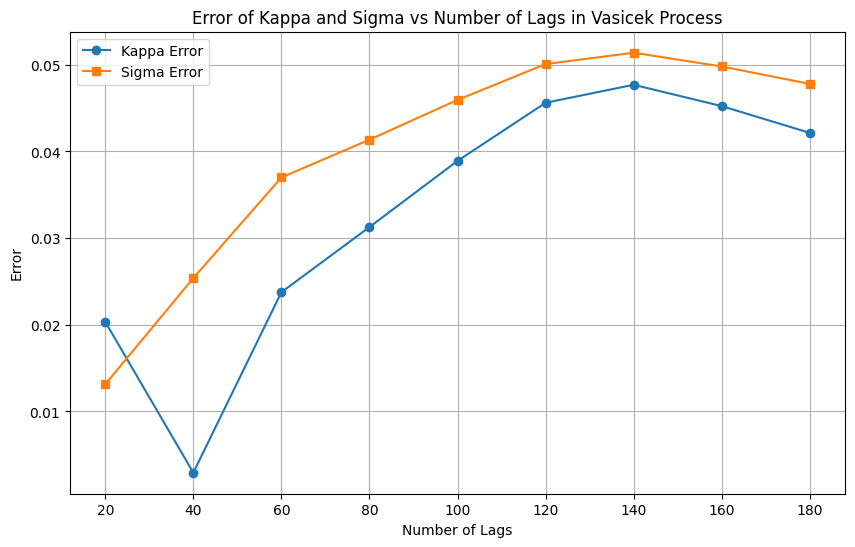

True kappa is: 1
True sigma is: 1
Estimated kappa is: 0.9578563574360851
Estimated sigma is: 0.9522083472358179


In [13]:
# Theoretical covariance function
def theoretical_covariance(h, kappa, sigma):
    return (sigma**2 / (2 * kappa)) * np.exp(-kappa * h)

# Empirical covariance function
def empirical_covariance(X, n, T, theta_emp, h):
    k0 = int(n * h / T)  # Convert lag h to index
    cov = 0
    for k in range(n - k0):
        cov += (X[k] * X[k + k0]) / (n - k0)
    return cov - theta_emp**2

# Function to estimate kappa and sigma
p0 = [3.9, 1.5]  # Initial guesses for kappa and sigma

def estimate_kappa_sigma(X, n, T, theta_emp, lags):
    def emp_cov(X, h):
        return empirical_covariance(X, n, T, theta_emp, h)
    
    # Calculate empirical covariances for the given lags
    covariances = np.array([emp_cov(X, h) for h in lags])
    
    # Fit the theoretical covariance function to the empirical covariances
    bounds = ([0, 0], [np.inf, np.inf])  # Ensure positive kappa and sigma
    params, _ = curve_fit(
        lambda h, kappa, sigma: theoretical_covariance(h, kappa, sigma),
        lags,
        covariances,
        p0=p0,
        bounds=bounds,
    )
    kappa, sigma = params
    return kappa, sigma


Empirical theta is: 0.08968131556412613
True theta is: 0.09
Number of Lags:  2
Number of Lags:  5


/tmp/ipykernel_1128256/3732467551.py:25: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(


Number of Lags:  8
Number of Lags:  11
Number of Lags:  14
Number of Lags:  17


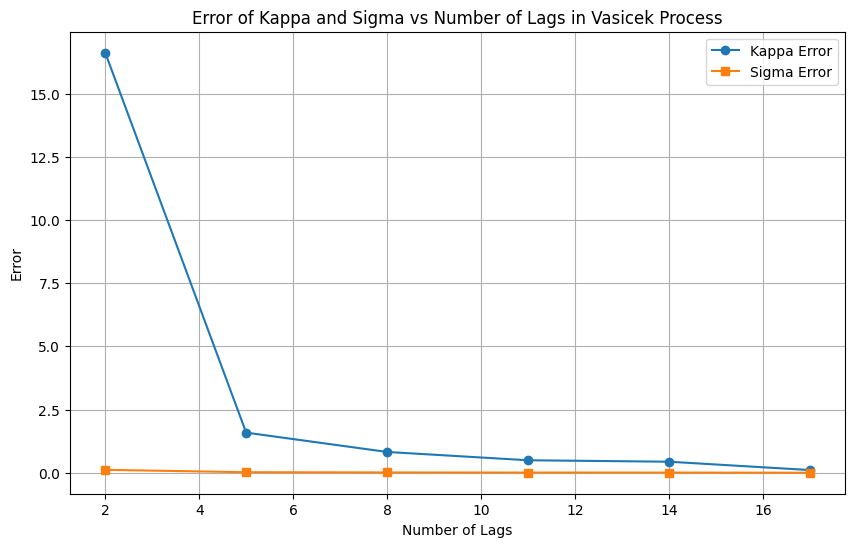

True kappa is: 0.892
True sigma is: 0.033
Estimated kappa is: 0.9987452404592935
Estimated sigma is: 0.03421172461553068


In [13]:

# Compute empirical mean
theta_emp = np.mean(trajectory)
print("Empirical theta is:", theta_emp)
print("True theta is:", theta_true)

# Define the range of lags
num_lags_list = np.arange(2, 20,3)  # Start with 20, increase by 20, up to 200
kappa_errors = []
sigma_errors = []
kappa_est = -1 
sigma_est = -1
# Loop over the number of lags to calculate errors
for num_lags in num_lags_list:
    print("Number of Lags: ", num_lags)
    lags = np.array([i * T / n for i in range(num_lags)])  # Define lags
    kappa_est, sigma_est = estimate_kappa_sigma(trajectory, n, T, theta_emp, lags)
    kappa_errors.append(np.abs(kappa_est - kappa_true))  # Absolute error for kappa
    sigma_errors.append(np.abs(sigma_est - sigma_true))  # Absolute error for sigma

# Plot the errors
plt.figure(figsize=(10, 6))
plt.plot(num_lags_list, kappa_errors, label='Kappa Error', marker='o')
plt.plot(num_lags_list, sigma_errors, label='Sigma Error', marker='s')
plt.xlabel('Number of Lags')
plt.ylabel('Error')
plt.title('Error of Kappa and Sigma vs Number of Lags in Vasicek Process')
plt.legend()
plt.grid(True)
plt.show()
print("True kappa is:", kappa_true)
print("True sigma is:", sigma_true)
print("Estimated kappa is:", kappa_est)
print("Estimated sigma is:", sigma_est)

<h1>Maximum Likelihood Estimator (MLE)</h1>


The fixed $\delta$ results for the maximum likelihood estimators of the Vasicek process are given in the following theorems.


## Parameter Estimation in the Vasicek Model

We estimate the parameters $\kappa$, $\alpha$, and $\sigma^2$ using the following equations from C.Y. Tang and S.X. Chen (2009):

\begin{align*}
    \hat{\kappa} = -\frac{1}{\delta} \log(\hat{\beta}_1), \quad 
    \hat{\alpha} = \hat{\beta}_2, \quad 
    \hat{\sigma}^2 = \frac{2\hat{\kappa} \hat{\beta}_3}{1 - \hat{\beta}_1^2}
\end{align*}

where

\begin{align*}
    \hat{\beta}_1 = \frac{\frac{1}{n} \sum\limits_{i=1}^{n} X_i X_{i-1} - 
    \left( \frac{1}{n} \sum\limits_{i=1}^{n} X_i \right) 
    \left( \frac{1}{n} \sum\limits_{i=1}^{n} X_{i-1} \right)}
    {\frac{1}{n} \sum\limits_{i=1}^{n} X_{i-1}^2 - 
    \left( \frac{1}{n} \sum\limits_{i=1}^{n} X_{i-1} \right)^2}
\end{align*}

\begin{align*}
    \hat{\beta}_2 = \frac{\frac{1}{n} \sum\limits_{i=1}^{n} (X_i - \hat{\beta}_1 X_{i-1})}{1 - \hat{\beta}_1}
\end{align*}

\begin{align*}
    \hat{\beta}_3 = \frac{1}{n} \sum\limits_{i=1}^{n} 
    \left( X_i - \hat{\beta}_1 X_{i-1} - \hat{\beta}_2 (1 - \hat{\beta}_1) \right)^2
\end{align*}




\begin{align*}
    B_1(\theta, \delta) &= \frac{5}{2} + e^{\kappa \delta} + e^{2\kappa \delta / 2}, \\
    B_2(\theta, \delta) &= -\sigma^2 \delta^{-1} 
    \left[ \kappa^{-1} 
    \left( 2 - \kappa \delta - \frac{1}{2} e^{2\kappa \delta} (1 - e^{-\kappa \delta}) \right) 
    - 4\delta(1 - e^{-2\kappa \delta})^{-1} e^{-2\kappa \delta} 
    \right], \\
    V_1(\theta, \delta) &= \delta^{-1} (e^{2\kappa \delta} - 1), \\
    V_2(\theta, \delta) &= \sigma^2 (2\kappa)^{-1} \delta (e^{\kappa \delta} - 1)^{-1} (e^{\kappa \delta} + 1), \\
    V_3(\theta, \delta) &= \sigma^4 (\kappa \delta)^{-2} 
    \left[ 2(\kappa \delta)^2 + (e^{\kappa \delta} - e^{-\kappa \delta}) 
    \left( 1 - \frac{2\kappa \delta e^{-2\kappa \delta}}{1 - e^{-2\kappa \delta}} \right) 
    \right].
\end{align*}

Theorem  : For a stationary Vasicek process, as $n \to \infty$ while $\delta$ is fixed,

\begin{align*}
    \mathbb{E}(\hat{\kappa}) &= \kappa + (n\delta)^{-1} B_1(\theta, \delta) + O(n^{-2}), \\
    \text{Var}(\hat{\kappa}) &= (n\delta)^{-1} V_1(\theta, \delta) + O(n^{-2}), \\
    \mathbb{E}(\hat{\alpha}) &= \alpha + O(n^{-2}), \\
    \text{Var}(\hat{\alpha}) &= (n\delta)^{-1} V_2(\theta, \delta) + O(n^{-2}), \\
    \mathbb{E}(\hat{\sigma}^2) &= \sigma^2 + n^{-1} B_2(\theta, \delta) + O(n^{-2}), \\
    \text{Var}(\hat{\sigma}^2) &= n^{-1} V_3(\theta, \delta) + O(n^{-2}).
\end{align*}


In [14]:
def negative_log_likelihood(params):
    """
    Compute the log-likelihood for the Vasicek process given parameters.
    
    :param sigma: Volatility parameter (standard deviation)
    :param theta: Long-term mean level
    :param kappa: Speed of mean reversion
    :param n: Number of discretization steps
    :param T: Total time period (default is 1)
    
    :return: Log-likelihood value
    """
    # Create the Vasicek process model with given parameters
 # Take the first trajectory as the observed data
    sigma, theta, kappa = params

    dt = T / n  # Time step size

    # Initialize log-likelihood value
    log_likelihood_value = 0

    # First part of the log-likelihood
    term1 = -n / 2 * np.log(sigma**2 / (2 * kappa * (1 - np.exp(-2 * kappa * dt))))
    log_likelihood_value += term1
    # Third part: Sum of squared residuals
    residual_sum = 0
    for i in range(1, n):
        expected_value = trajectory[i - 1] * np.exp(-kappa * dt) + theta * (1 - np.exp(-kappa * dt))
        residual = trajectory[i] - expected_value
        residual_sum += residual**2
    
    # Fourth part: the sum over residuals
    term3 = -(kappa / (sigma**2 * (1 - np.exp(-2 * kappa * dt)))) * residual_sum
    log_likelihood_value += term3

    return -log_likelihood_value


In [15]:
def estimate_parameters(trajectory = trajectory, T = T):
    n = len(trajectory)
    delta_t = T / n
    Rt = np.array(trajectory)
    
    # Calculate terms
    Rt_shifted = Rt[:-1]  # R_{t_{i-1}}
    Rt_current = Rt[1:]  # R_{t_i}
    
    #  (kappa)
    mean_RtRt_shifted = np.mean(Rt_current * Rt_shifted)
    mean_Rt = np.mean(Rt_current)
    mean_Rt_shifted = np.mean(Rt_shifted)
    mean_Rt_shifted_squared = np.mean(Rt_shifted ** 2)
    
    numerator_alpha = mean_RtRt_shifted - mean_Rt * mean_Rt_shifted
    denominator_alpha = mean_Rt_shifted_squared - mean_Rt_shifted ** 2
    kappa = -1 / delta_t * np.log(numerator_alpha / denominator_alpha)
    
    #  (theta)
    numerator_theta = np.sum(Rt_current) - np.exp(kappa * delta_t) * np.sum(Rt_shifted)
    denominator_theta = n * (1 - np.exp(-kappa * delta_t))
    theta = numerator_theta / denominator_theta
    
    # sigma^2
    term1 = Rt_current - Rt_shifted * np.exp(-kappa * delta_t)
    term2 = theta * (1 - np.exp(-kappa * delta_t))
    sigma_squared = (2 * kappa) / (n * (1 - np.exp(-2 * kappa * delta_t))) * np.sum((term1 - term2) ** 2)
    
    return kappa, theta, np.sqrt(sigma_squared)
kappa, theta, sigma = estimate_parameters()
print('kappa is ', kappa)
print('theta is ', abs(theta))
print('sigma is ', sigma)
print('true kappa is ', kappa_true)
print('true theta is ',abs( theta_true))
print('true sigma is', sigma_true)


kappa is  1.0507843627959352
theta is  0.5666409840670228
sigma is  1.0088893756601423
true kappa is  1
true theta is  0.5
true sigma is 1


## Comparison of MLE and GMM

Here we compare both the MLE and GMM

In [16]:
def MSE(params,true_params):
    return np.mean((params - true_params) ** 2)

theta_emp  0.09100322808120927
theta_emp  0.08885126686111194
theta_emp  0.09050784558779687
theta_emp  0.0903325696569985
theta_emp  0.08929347525409792
theta_emp  0.09211143733449781
theta_emp  0.08987195527301081
theta_emp  0.08756404908036354
theta_emp  0.09031880652980974
theta_emp  0.08943984503792081
theta_emp  0.08848412894711137
theta_emp  0.08937300546523955
theta_emp  0.09124508258577173


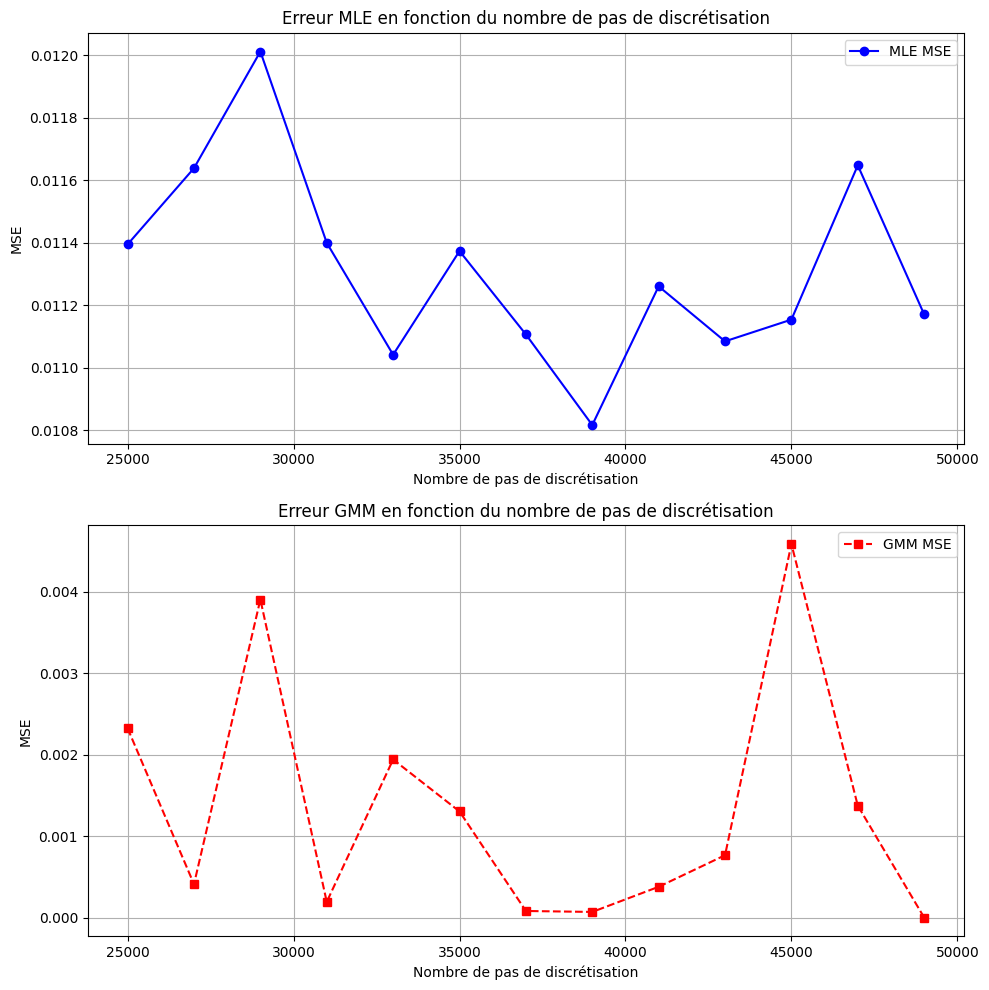

In [21]:

# Paramètres du processus
n_range = range(25000, 50000, 2000)

N = 1
X0 = 0.05  # Valeur initiale du processus
kappa_true = 0.892  # Vitesse de retour à la moyenne
theta_true = 0.09  # Moyenne long-terme
sigma_true = 0.033  # Volatilité

MLE_error = []
num_lags = 80
GMM_error = []

for n in n_range:
    T = 1000
    vasicek_process = Vasicek(kappa_true, theta_true, sigma_true)
    trajectory = vasicek_process.generate(X0, T, N, n)[0]  # Générer une trajectoire

    kappa_MLE, theta_MLE, sigma_MLE = estimate_parameters(trajectory, T)

    # Calcul de l'erreur pour le MLE
    MLE_error.append(MSE(
        np.array([kappa_MLE, theta_MLE, sigma_MLE]),
        np.array([kappa_true, theta_true, sigma_true])
    ))

    # Estimation par la méthode des moments (GMM)
    theta_emp = np.mean(trajectory)
    print('theta_emp ',theta_emp)
    lags = np.array([i * T / n for i in range(num_lags)])  # Éviter trop de lags
    kappa_est, sigma_est = estimate_kappa_sigma(trajectory, n, T, theta_emp, lags)

    GMM_error.append(MSE(
        np.array([kappa_est, theta_emp, sigma_est]),
        np.array([kappa_true, theta_true, sigma_true])
    ))

# Création des sous-figures
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Graphique pour MLE
axs[0].plot(n_range, MLE_error, label='MLE MSE', marker='o', color='b')
axs[0].set_xlabel('Nombre de pas de discrétisation')
axs[0].set_ylabel('MSE')
axs[0].set_title('Erreur MLE en fonction du nombre de pas de discrétisation')
axs[0].legend()
axs[0].grid(True)

# Graphique pour GMM
axs[1].plot(n_range, GMM_error, label='GMM MSE', marker='s', linestyle='dashed', color='r')
axs[1].set_xlabel('Nombre de pas de discrétisation')
axs[1].set_ylabel('MSE')
axs[1].set_title('Erreur GMM en fonction du nombre de pas de discrétisation')
axs[1].legend()
axs[1].grid(True)

# Affichage des graphiques
plt.tight_layout()
plt.show()


Epoch [1/5], Loss: 1.1311
Epoch [2/5], Loss: 0.5908
Epoch [3/5], Loss: 0.5186
Epoch [4/5], Loss: 0.4941
Epoch [5/5], Loss: 0.4776


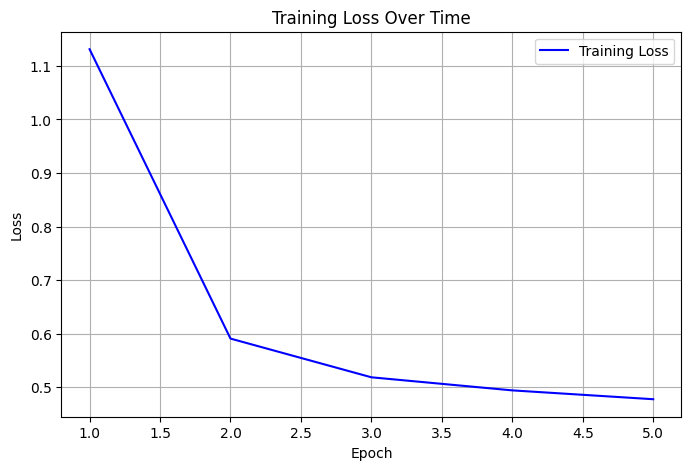

In [63]:

df = pd.read_csv("/home/hassene/Desktop/Imi_proj/Document/vasicek_results.csv")

# Convert DataFrame to NumPy arrays
X = df.iloc[:, :-3].values  # All columns except last 3 (input features)
y = df.iloc[:, -3:].values  # Last 3 columns (output labels)

# Standardize the features before creating dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)

# PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Get input feature size dynamically
input_size = X.shape[1]

# Model with Xavier Initialization
class Module(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, 25)
        self.fc3 = nn.Linear(25, 3)
        self.relu = nn.ReLU()
        self._init_weights()
    
    def _init_weights(self):
        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize Model
model = Module()

# Loss & Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Lower learning rate

# Training Loop
num_epochs = 5
losses = []  # List to store loss values

for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)  # Compute average loss per epoch
    losses.append(epoch_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Plot loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), losses, label="Training Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Load Test Data
data_test = pd.read_csv("/home/hassene/Desktop/Imi_proj/Document/vasicek_test.csv")
X_test = data_test.iloc[:, :-3].values
y_test = data_test.iloc[:, -3:].values

# Standardize Test Data Before Creating Dataset
X_test = scaler.transform(X_test)
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate Model
model.eval()
test_loss = 0
num_samples = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        batch_size = batch_X.shape[0]
        test_loss += loss.item() * batch_size
        num_samples += batch_size

        print("outputs: ", outputs[0])
        print("batch_y: ", batch_y[0])

test_loss /= num_samples  # True average test loss
print(f"Test Loss: {test_loss:.4f}")


outputs:  tensor([1.9002, 1.1927, 0.7073])
batch_y:  tensor([1.0000, 1.2222, 1.0000])
outputs:  tensor([1.6424, 1.6443, 1.7938])
batch_y:  tensor([1.0000, 1.6667, 1.6667])
outputs:  tensor([1.2150, 2.0823, 2.6037])
batch_y:  tensor([1.0000, 2.1111, 2.3333])
outputs:  tensor([0.6603, 2.4332, 2.3510])
batch_y:  tensor([1.0000, 2.5556, 3.0000])
outputs:  tensor([1.9061, 2.9896, 1.3037])
batch_y:  tensor([1.2222, 3.0000, 1.4444])
outputs:  tensor([1.0626, 1.2009, 2.0743])
batch_y:  tensor([1.2222, 1.2222, 2.3333])
outputs:  tensor([1.0881, 1.6450, 2.8258])
batch_y:  tensor([1.2222, 1.6667, 3.0000])
outputs:  tensor([1.4542, 2.0893, 0.7788])
batch_y:  tensor([1.4444, 2.1111, 1.4444])
outputs:  tensor([2.6638, 2.5727, 2.6043])
batch_y:  tensor([1.4444, 2.5556, 2.1111])
outputs:  tensor([1.3877, 3.0264, 2.6089])
batch_y:  tensor([1.4444, 3.0000, 2.7778])
outputs:  tensor([1.9197, 1.1904, 0.8562])
batch_y:  tensor([1.6667, 1.2222, 1.4444])
outputs:  tensor([2.5853, 1.6309, 2.3416])
batch_y:  t

In [65]:

"""
# Parameters for Vasicek
kappa_true = 1  # True speed of mean reversion
theta_true = 0.5  # True long-term mean
sigma_true = 0.2  # True volatility
n = 1000
num_lags_list = np.arange(20, 100, 20)  # List of lags to evaluate

# Values for kappa, theta, sigma
values = np.linspace(0.1, 5, 10)  # Range for the parameters
label = []
num_lags = 90
total = 0 
results = []
for n in range(1000, 10000, 400):
        for kappa in values:
            for sigma in values:
                for theta in values:
                    total+=1
                    vasicek_process = Vasicek(kappa, theta, sigma)
                    X0 = np.random.uniform(0, 1)  # Initial value of the process
                    T = np.random.randint(100, 5000)  # Random total time period
                    N = 1  # Single trajectory
                    
                    # Generate the lag array
                    lags = np.array([i * T / n for i in range(num_lags)])
                    # Generate the trajectory
                    trajectory = vasicek_process.generate(X0, T, N, n)[0]
                    print(f"Kappa: {kappa}, Theta: {theta}, Sigma: {sigma}, N: {N}, n: {n}")
                    result_temp = []
                    # Calculate expected values for different powers
                    for power in range(10):
                        expected = expected_value_vasicek(power, theta, sigma, kappa)
                        result_temp.append(expected)
                    
                    # Calculate empirical covariance
                    theta_emp = np.mean(trajectory)                
                    covariances = np.array([emp_cov(trajectory, h, n, T, theta_emp) for h in lags])
                    for x in covariances:
                        result_temp.append(x)
                    
                    results.append(result_temp)
                    print(len(result_temp))
                    label.append((kappa, theta, sigma)) 

print(total)
# Create DataFrame from results
column_names = [f"Expected_{i}" for i in range(10)] + [f"Covariance_{i}" for i in range(num_lags)]
df_results = pd.DataFrame(results, columns=column_names)

# Add kappa, theta, sigma columns
df_results['Kappa'] = [x[0] for x in label]
df_results['Theta'] = [x[1] for x in label]
df_results['Sigma'] = [x[2] for x in label]

# Save to CSV
df_results.to_csv("vasicek_results.csv", index=False)

print(f"Total calculations: {total}")"""

'\n# Parameters for Vasicek\nkappa_true = 1  # True speed of mean reversion\ntheta_true = 0.5  # True long-term mean\nsigma_true = 0.2  # True volatility\nn = 1000\nnum_lags_list = np.arange(20, 100, 20)  # List of lags to evaluate\n\n# Values for kappa, theta, sigma\nvalues = np.linspace(0.1, 5, 10)  # Range for the parameters\nlabel = []\nnum_lags = 90\ntotal = 0 \nresults = []\nfor n in range(1000, 10000, 400):\n        for kappa in values:\n            for sigma in values:\n                for theta in values:\n                    total+=1\n                    vasicek_process = Vasicek(kappa, theta, sigma)\n                    X0 = np.random.uniform(0, 1)  # Initial value of the process\n                    T = np.random.randint(100, 5000)  # Random total time period\n                    N = 1  # Single trajectory\n                    \n                    # Generate the lag array\n                    lags = np.array([i * T / n for i in range(num_lags)])\n                    # Gene